# Zadanie 1 – analýza tweetov  
Odovzdanie do 10.10.2021 23:59 – máte na to presne 2 týždne – dostanete za to 7,5 boda. 
 
Prvé zadanie je zamerané na roztriedenie tweetov medzi rôzne konšpiračné teórie uvedené 
pod zadaním. Programovať môžete v hocijakom jazyku a váš zdroják sa odovzdáva to IS, no 
rovnako MUSÍ byť zavesený na vašom githube – v dokumente na začiatku uveďte vždy linku 
na projekt. Ak nebude GitHub, nebudú body. Okrem zdrojáku odovzdávate aj dokument kde 
budú screenshoty vašich výsledkov, výsledky ako text a grafy. Môžete napísať aj nejaké teplé 
slovko k tomu, nech sa pobavíme. 
 
Vašou úlohou je teda: 
 
1. Importovať dataset do PostgreSQL 13+: 
https://drive.google.com/drive/folders/1_crPerzWU2Nzc4mR5k6xuGqbp0fJDvsY?usp=sharing 
 
2. Vypočítať sentiment pomocou VADER lexikónu 
https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664 pre 
tweety, ktoré obsahujú nasledovné hashtagy: #DeepstateVirus #DeepStateVaccine 
#DeepStateFauci #QAnon #Agenda21 #CCPVirus #ClimateChangeHoax 
#GlobalWarmingHoax #ChinaLiedPeopleDied #SorosVirus #5GCoronavirus #MAGA 
#WWG1WGA #Chemtrails #flatEarth #MoonLandingHoax #moonhoax #illuminati 
#pizzaGateIsReal #PedoGateIsReal #911truth #911insidejob #reptilians 
Pri výpočte nezohľadňujte (ignorujte) emotikony ani hashtagy ani mentiony v texte. 
 
3. Roztriediť vyfiltrované tweety z predošlého zadania medzi konšpiračné teórie – 
spravte si na to novú tabuľku a mapovanie – nech je jasné ktorý tweet patrí ktorej 
konšpiračnej teórii.  
 
4. Vypočítajte pomer extrémnych a neutrálnych sentimentov tweetov pre konšpiračné 
teórie po týždňoch a zistite, či daná konšpiračná teória rastie alebo upadá v čase. 
Výstup vizualizujte v grafe. Rovnako uveďte aj absolútne čísla: tweet_count, 
tweet_extreme_count, tweet_neutral_count v tabuľke pre každý týždeň. Za extrém 
považujeme keď je compound väčší ako 0,5 alebo menší ako -0,5. 
 
5. Nájdite TOP10 account-ov ktoré sú najaktívnejšie v každej konšpiračnej teórii 
s extrémnym sentimentom a ukážte ich v tabuľke: id, name, screen_name a 
tweet_count. 
 
6. Nájdite TOP10 najčastejšie používaných hashtagov pre každú konšpiračnú teóriu 
z tweetov s extrémnym sentimentom, vypíšte aj počet. 
 
V úvahu berte nasledovné konšpiračné teórie a ich hashtagy.

## Database structure

![DB structure](Zadanie1-TweetsDB.jpeg)

# === Conspiracy Theories ===

## Deep State  
 
https://en.wikipedia.org/wiki/Deep_state 
 
A deep state is a type of governance made up of potentially secret and unauthorised 
networks of power operating independently of a state's political leadership in pursuit of 
their own agenda and goals. In popular usage, the term carries overwhelmingly negative 
connotations. The range of possible uses of the term is similar to that for shadow 
government. The expression state within a state is an older and similar concept. Historically, 
it designated a well-defined organization which seeks to function independently, whereas 
the deep state refers more to a hidden organization seeking to manipulate the public state. 
 
`#DeepstateVirus #DeepStateVaccine #DeepStateFauci`

## Qanon  
 
https://dennikn.sk/2474994/pripraveni-na-velke-prebudenie-zo-zakulisia-hnutia-qanon/ 
 
“The [QAnon] conspiracy involves a range of batshit theories but very basically, many 
QAnon supporters believe in a global conspiracy involving a ring of Satan-worshipping, child-
molesting criminals led by prominent Democrats that includes everyone from Hillary Clinton 
to Tom Hanks to a Mexican cement company [Cemex]. They also believe information about 
it is being leaked via cryptic posts on the internet by someone with very high Q-level 
security clearance—which sounds just as made-up as it definitely is.” 
 
`#QAnon #MAGA #WWG1WGA`

## New world order  
 
https://www.buzzfeed.com/joeydurso/coronavirus-agenda-21-5g

An Old Conspiracy Theory Known As "Agenda 21" Has Been Rebooted By The Coronavirus 
Pandemic. New World Order is here again. 
 
`#Agenda21`

## The virus escaped from a Chinese lab  
 
https://www.vox.com/22453571/lab-leak-covid-19-coronavirus-hypothesis-wuhan-virology-china 
 
Where did the virus that causes Covid-19 come from? It’s one of the most persistent 
mysteries of the pandemic. The debate about it among scientists, policymakers, journalists, 
amateur internet sleuths, and the general public has reignited with new revelations and 
new voices in the mix. We may never know for sure if the virus that causes Covid-19 leaked 
from a lab. But that won’t stop the debate. 
 
`#CCPVirus #ChinaLiedPeopleDied`

## Global Warming is HOAX  
 
https://www.hull.ac.uk/special/blog/why-people-still-believe-climate-change-is-fake-and-
why-we-know-theyre-wrong 
 
Why people still believe climate change is fake...

`#ClimateChangeHoax #GlobalWarmingHoax`

## COVID19 and microchipping  
 
https://www.politifact.com/factchecks/2020/may/28/facebook-posts/theres-no-plot-
microchip-people-during-covid-19-te/ 
 
There’s no evidence that Bill Gates and George Soros plan to microchip people being tested 
for coronavirus. 
 
`#SorosVirus #BillGAtes`

## COVID19 is preaded by 5G  
 
https://www.vox.com/recode/2020/4/24/21231085/coronavirus-5g-conspiracy-theory-
covid-facebook-youtube 
 
The first link John Gregory saw pushing a connection between 5G and the coronavirus 
pandemic was on a French conspiracy website called Les moutons enragés, which loosely 
translates as “The rabid sheep.” A January 20 post floated that the millimeter wave 
spectrum used by 5G technology and Covid-19, the disease caused by the novel coronavirus, 
could be related, pointing to reports about Wuhan installing 5G towers before the outbreak. 
Three months later, conspiracy theorists making similar claims were setting cellphone 
towers on fire in Europe. 
 
`#5GCoronavirus`

## Moon landing is fake  
 
https://www.space.com/apollo-11-moon-landing-hoax-believers.html 
 
Moon-Landing Hoax Still Lives On, 50 Years After Apollo 11. 
 
`#MoonLandingHoax #moonhoax`

## 9/11 was inside job  
 
https://www.bbc.com/news/58469600 
 
11 September 2001: The conspiracy theories still spreading after 20 years 
 
`#911truth #911insidejob`

## Pizzagate conspiracy theory 
 
(https://en.wikipedia.org/wiki/Pizzagate_conspiracy_theory 
 
In March 2016, the personal email account of John Podesta, Hillary Clinton's campaign chair, 
was hacked in a spear-phishing attack. WikiLeaks published his emails in November 2016. 
Proponents of the Pizzagate conspiracy theory falsely claimed the emails contained coded 
messages that connected several high-ranking Democratic Party officials and U.S. 
restaurants with an alleged human trafficking and child sex ring. One of the establishments 
allegedly involved was the Comet Ping Pong pizzeria in Washington, D.C.[6][7] 
 
`#pizzaGateIsReal #PedoGateIsReal`

## Chemtrails  
 
https://keith.seas.harvard.edu/chemtrails-conspiracy-theory 
 
Chemtrails refers to the theory that governments or other parties are engaged in a secret 
program to add toxic chemicals to the atmosphere from aircraft in a way that forms visible 
plumes in the sky, somewhat similar to contrails. Various different motivations for this 
alleged spraying are speculated, including sterilization, reduction of life expectancy, mind 
control or weather control. 
 
`#Chemtrails`

## Flat Earth  
 
https://edition.cnn.com/2019/11/16/us/flat-earth-conference-conspiracy-theories-scli-intl/index.html 
 
(CNN)"I don't want to be a flat Earther," David Weiss says, his voice weary as he reflects on 
his personal awakening. "Would you wake up in the morning and want everyone to think 
you're an idiot?" But Weiss is a flat Earther. Ever since he tried and failed to find proof of the 
Earth's curve four years ago, he's believed with an evident passion that our planet is both 
flat and stationary -- and it's turned his world upside down. 
 
`#flatEarth`

## Illuminati  
 
https://www.bbc.com/future/article/20170809-the-accidental-invention-of-the-illuminati-
conspiracy 
It’s the conspiracy theory to dwarf all conspiracy theories. A smorgasbord of every other 
intrigue under the sun, the Illuminati are the supposed overlords controlling the world’s 
affairs, operating secretly as they seek to establish a New World Order. 
 
`#illuminati`

## Reptilian conspiracy theory  
 
https://en.wikipedia.org/wiki/Reptilian_conspiracy_theory 
 
Reptilians – also called reptoids, lizard people, reptiloids, saurians, or draconians – are 
supposed reptilian humanoids, which play a prominent role in fantasy, science fiction, 
ufology, and conspiracy theories. The idea of reptilians was popularised by David Icke, a 
conspiracy theorist who claims shapeshifting reptilian aliens control Earth by taking on 
human form and gaining political power to manipulate human societies. Icke has stated on 
multiple occasions that many world leaders are, or are possessed by, so-called reptilians. 
 
`#reptilians`

# === Solution ===
## by Bc. Juraj Baráth

## Task 1 - Import dataset to PostgreSQL

#### Step 1: Install postgis extension
`apt install -y postgis postgresql-postgis`

#### Step 2: Create new empty database
`su postgres`

`psql`
```
CREATE DATABASE tweets;
quit;
```
`logout`

#### Step 3: Import the database 
`screen -dmS pdt pg_restore -v -d tweets tweets.backup`

## Task 2 - Sentiment Calculation using VADER

#### Step 1: Grant read only access to a new database user
`su postgres`

`psql -d tweets`

```
CREATE USER pdt with password '9kRoaGZN5EcgTeDM';
GRANT CONNECT ON DATABASE tweets TO pdt;
GRANT USAGE ON SCHEMA public TO pdt;
GRANT SELECT ON ALL TABLES IN SCHEMA public TO pdt;
quit;
```

`logout`

#### Step 2: Install pip
`apt install -y python3-pip`

#### Step 3: Install postgresql connector (psycopg2) dependencies
`apt-get install -y libpq-dev`

#### Step 4: Install postgresql connector (psycopg2)
`pip install psycopg2`

#### Step 5: Install nb_black for automatic code reformatting
`pip install nb_black`

#### Step 6: Setup dependencies & application settings

In [1]:
# Uncomment the following line to automatically reformat python code
# %load_ext lab_black

In [2]:
# Application Settings
THREADS = 8

DB_HOST = "localhost"
DB_DATABASE = "tweets"
DB_USER = "pdt"
DB_PASSWORD = "9kRoaGZN5EcgTeDM"

In [3]:
# Setup Vader Sentiment Intensity Analyzer
import nltk

nltk.download("vader_lexicon")

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Postgresql connector
from psycopg2 import connect

# Thread management
from threading import Lock, get_ident
from multiprocessing.pool import Pool

# Error reporting
import traceback

In [5]:
# 2D array pretty printer utility
def print_2d(data):
    # Ignore empty data
    if len(data) == 0:
        return

    # Do not pretty print if first row is too long
    if sum(len(str(s)) for s in data[0]) > 70:
        for r in data:
            print(r, end="\n\n")
        return

    # Calculate string length for all elements
    data_len = []
    for row in data:
        data_len.append(list([len(str(i)) for i in row]))

    # Calculate max length of each column
    col_len = []
    for col in range(len(data_len[0])):
        l = []
        for row in data_len:
            l.append(row[col])
        col_len.append(max(l))

    # Generate row separator & use it for the first line
    sep = "\n+"
    for cl in col_len:
        sep += "-" * (cl + 2) + "+"
    sep += "\n"
    output = sep

    for row in data:
        # Generate line with the row's contents
        i = 0
        for column in row:
            output += "|" + " {:^{width}s} ".format(str(column), width=col_len[i])
            i += 1

        # Append column closer character & row separator
        output += "|" + sep

    # Print the generated output
    print(output)


# Error printer
def print_err(e):
    print(e.__cause__)

#### Step 7: Create database connection utility class

In [6]:
# Connect to database using a pool of 8 connections
def db():
    con = connect(
        host=DB_HOST, database=DB_DATABASE, user=DB_USER, password=DB_PASSWORD
    )
    con.autocommit = True
    return con.cursor()


cur = db()
print("Connected to database")

Connected to database


#### Step 8: Describe available tables

In [7]:
# List available tables
def list_tables(schema):
    cur.execute("select tablename from pg_tables where schemaname='" + schema + "'")
    tables = (
        [a[0] for a in cur.fetchall()]
        if schema == "public"
        else [schema + "." + a[0] for a in cur.fetchall()]
    )
    tables.sort()
    print("Available tables:", tables)
    return tables


tables = list_tables("public")

Available tables: ['accounts', 'countries', 'hashtags', 'spatial_ref_sys', 'tweet_hashtags', 'tweet_mentions', 'tweets']


In [8]:
# Describe tables
def describe_tables(tables):
    desc_row = [
        ["Column Name", "Data Type", "Max Char Len", "Default Value", "Nullable"]
    ]
    for t in tables:
        print("Table " + t + ":")
        d = t.split(".")
        schema = "public" if len(d) == 1 else d[0]
        cur.execute(
            "select column_name, data_type, character_maximum_length, column_default, is_nullable "
            + "from INFORMATION_SCHEMA.COLUMNS where table_name = '"
            + d[-1]
            + "' and table_schema = '"
            + schema
            + "'"
        )
        print_2d(desc_row + cur.fetchall())
        print("")


describe_tables(tables)

Table accounts:

+-----------------+-------------------+--------------+--------------------------------------+----------+
|   Column Name   |     Data Type     | Max Char Len |            Default Value             | Nullable |
+-----------------+-------------------+--------------+--------------------------------------+----------+
|       id        |      bigint       |     None     | nextval('accounts_id_seq'::regclass) |    NO    |
+-----------------+-------------------+--------------+--------------------------------------+----------+
|   screen_name   | character varying |     200      |                 None                 |   YES    |
+-----------------+-------------------+--------------+--------------------------------------+----------+
|      name       | character varying |     200      |                 None                 |   YES    |
+-----------------+-------------------+--------------+--------------------------------------+----------+
|   description   |       text        

In [9]:
# Show sample data
def sample_tables(tables, limit=10):
    for t in tables:
        print("Table " + t + ":")
        cur.execute("SELECT * FROM " + t + " LIMIT " + str(limit))
        print_2d(cur.fetchall())
        print("")


sample_tables(tables)

Table accounts:
(280887543, 'carol_cabural', 'Caroline Cabural ♔', "Always look at things from the other person's perspective.\n-Dale Carnegie \nGarde Manger Chef| Hospitality Industry | Filipino", 657, 1482, 4650)

(519245371, 'strong_sue', 'Sue Strong 🇺🇸🇦🇺🇨🇦🇳🇿🇬🇧 #BidenHarris2020', '#HearHim, #ChurchOfJesusChrist, #StandUpRepublic, #TeamPatriot, #CountryOverParty, #ETTD, #Cats, #MS, TSB, GTT, #PAM, #PAMFAM #TeamJoe', 1469, 2636, 53614)

(761224507, 'Chn_analysis', 'Paul Harding', '', 150, 357, 4993)

(905154964829462528, 'thespybrief', 'The Spy Brief', None, None, None, None)

(707774148072882176, 'hiemakene', 'GoneFishing', None, None, None, None)

(1133475349285691393, 'KtyWise', 'Kty Wise', '', 161, 241, 21786)

(532977876, 'Adrienne711', 'NeverGiveUp ⭐⭐⭐ 🐸', 'Trump2020 WWG1WGA  1A 2A AMERICA FIRST -  I ♥ God Country  & our President Donald J Trump   UnitedNotDivided WWG1WGA\nShadilay!', 7335, 7033, 132331)

(949056207448432640, 'MBJ8388', "MBJ👩\u200d💻NoFilters💥Q'Nited✨", None, Non

#### Step 9: Create hashtag -> conspiracy mapping

In [10]:
# Create list of conspiracy theories
conspiracies = (
    "Deep State",
    "Qanon",
    "New world order",
    "The virus escaped from a Chinese lab",
    "Global Warming is HOAX",
    "COVID19 and microchipping",
    "COVID19 is preaded by 5G",
    "Moon landing is fake",
    "9/11 was inside job",
    "Pizzagate conspiracy theory",
    "Chemtrails",
    "Flat Earth",
    "Illuminati",
    "Reptilian conspiracy theory",
)

# Map hashtags to the list of conspiracy theories
hashtag_conmap = {
    "#DeepstateVirus": 0,
    "#DeepStateVaccine": 0,
    "#DeepStateFauci": 0,
    "#QAnon": 1,
    "#MAGA": 1,
    "#WWG1WGA": 1,
    "#Agenda21": 2,
    "#ChinaLiedPeopleDied": 3,
    "#CCPVirus": 3,
    "#ClimateChangeHoax": 4,
    "#GlobalWarmingHoax": 4,
    "#SorosVirus": 5,  # '#BillGAtes':5
    "#5GCoronavirus": 6,
    "#MoonLandingHoax": 7,
    "#moonhoax": 7,
    "#911truth": 8,
    "#911insidejob": 8,
    "#pizzaGateIsReal": 9,
    "#PedoGateIsReal": 9,
    "#Chemtrails": 10,
    "#flatEarth": 11,
    "#illuminati": 12,
    "#reptilians": 13,
}

# Print the generated mappings in alphabetical order
hashtags = list(hashtag_conmap.keys())
hashtags.sort(key=lambda e: e.upper())
rows = [["Hashtag", "Conspiracy Theory"]]
for t in hashtags:
    rows.append([t, conspiracies[hashtag_conmap[t]]])
print_2d(rows)


+----------------------+--------------------------------------+
|       Hashtag        |          Conspiracy Theory           |
+----------------------+--------------------------------------+
|    #5GCoronavirus    |       COVID19 is preaded by 5G       |
+----------------------+--------------------------------------+
|    #911insidejob     |         9/11 was inside job          |
+----------------------+--------------------------------------+
|      #911truth       |         9/11 was inside job          |
+----------------------+--------------------------------------+
|      #Agenda21       |           New world order            |
+----------------------+--------------------------------------+
|      #CCPVirus       | The virus escaped from a Chinese lab |
+----------------------+--------------------------------------+
|     #Chemtrails      |              Chemtrails              |
+----------------------+--------------------------------------+
| #ChinaLiedPeopleDied | The virus esca

#### Step 10: Fetch hashtag -> hashtag-ids mapping

In [11]:
hashtag_idmap = {}


def fetch_hashtag_ids(hashtag):
    # Since the dataset does not respect our case conventions, we are doing a case insensitive search
    # We are also looking for hashtags with & without the # prefix
    cur.execute(
        "SELECT id FROM hashtags WHERE LOWER(value) = '"
        + hashtag[1:].lower()
        + "' "
        + "OR LOWER(value) = '"
        + hashtag[1:].lower()
        + "'"
    )
    rows = cur.fetchall()

    # Save the results to a list of ids, map the list to the given hashtag
    ids = list(map(lambda r: r[0], rows))
    hashtag_idmap[hashtag] = ids
    print(t, "->", ids)


for t in hashtags:
    fetch_hashtag_ids(t)

#5GCoronavirus -> [19005036, 35538816, 15552438, 34619065]
#911insidejob -> [16074404]
#911truth -> [7014593, 2525313]
#Agenda21 -> [66445, 111971, 363281]
#CCPVirus -> [18509464, 3073063, 10905016, 1137275, 29467281, 31317877, 34584873, 34691278, 1379885]
#Chemtrails -> [15171991, 149294, 33792, 905802]
#ChinaLiedPeopleDied -> [16685336, 23714496, 23538315, 25456041, 5112446, 26615200, 27219903, 36886795]
#ClimateChangeHoax -> [14157066, 159068, 10090147]
#DeepStateFauci -> [15870712, 16542067]
#DeepStateVaccine -> [17407797]
#DeepstateVirus -> [18007452, 7074589]
#flatEarth -> [18277418, 20256863, 4209470, 7529160, 3436024]
#GlobalWarmingHoax -> [3486140, 4673374]
#illuminati -> [16238392, 875154, 3178025, 967857]
#MAGA -> [15894243, 17899079, 19261059, 19469799, 19898566, 88504, 24818, 14415]
#moonhoax -> [18587371]
#MoonLandingHoax -> [19604351]
#PedoGateIsReal -> [15550095, 15659618, 2741960, 15268807, 7832331, 6005507]
#pizzaGateIsReal -> [15188058, 15673159, 17812154, 18874438, 

#### Step 11: Fetch hashtag -> tweet-id mapping

In [12]:
hashtag_twmap = {}
for t in hashtags:
    twids = set()
    for hid in hashtag_idmap[t]:
        cur.execute(
            "SELECT tweet_id FROM tweet_hashtags WHERE hashtag_id = " + str(hid)
        )
        rows = cur.fetchall()
        for r in rows:
            twids.add(r[0])
    hashtag_twmap[t] = twids
    print(t, "-> mapped", len(twids), "tweets")

#5GCoronavirus -> mapped 407 tweets
#911insidejob -> mapped 4 tweets
#911truth -> mapped 139 tweets
#Agenda21 -> mapped 2297 tweets
#CCPVirus -> mapped 5024 tweets
#Chemtrails -> mapped 1044 tweets
#ChinaLiedPeopleDied -> mapped 3261 tweets
#ClimateChangeHoax -> mapped 53 tweets
#DeepStateFauci -> mapped 183 tweets
#DeepStateVaccine -> mapped 14 tweets
#DeepstateVirus -> mapped 518 tweets
#flatEarth -> mapped 340 tweets
#GlobalWarmingHoax -> mapped 5 tweets
#illuminati -> mapped 2172 tweets
#MAGA -> mapped 207933 tweets
#moonhoax -> mapped 11 tweets
#MoonLandingHoax -> mapped 6 tweets
#PedoGateIsReal -> mapped 342 tweets
#pizzaGateIsReal -> mapped 3253 tweets
#QAnon -> mapped 2126183 tweets
#reptilians -> mapped 64 tweets
#SorosVirus -> mapped 7 tweets
#WWG1WGA -> mapped 697307 tweets


#### Step 12: Create the list of analysable tweets

In [13]:
tweet_ids = set()
for t in hashtags:
    tweet_ids.update(list(hashtag_twmap[t]))
tweet_ids = list(tweet_ids)
tweet_count = len(tweet_ids)
print("Found", tweet_count, "analysable tweets")

Found 2144772 analysable tweets


#### Step 13: Fetch tweets (multi-threaded)

In [14]:
def fetch_tweets(fr, to):
    tweets = {}
    with db() as cur:
        cur.execute(
            "SELECT id,content FROM tweets WHERE id IN ("
            + str(tweet_ids[fr:to])[1:-1]
            + ")"
        )
        rows = cur.fetchall()
        for r in rows:
            tweets[r[0]] = r[1]
    return tweets


tweets = {}
print("Fetching tweets, please wait...")
with Pool(THREADS) as p:
    for i in range(0, tweet_count, 100000):
        to = min(tweet_count, i + 100000)
        p.apply_async(
            fetch_tweets,
            (i, to),
            callback=lambda tw: tweets.update(tw),
            error_callback=print_err,
        )
    p.close()
    p.join()
print("Fetched " + str(len(tweets)) + " tweets\n", end="")

Fetching tweets, please wait...
Fetched 2144772 tweets


#### Step 14: Remove emoticons, hashtags, mentions from tweets (multi-threaded)

In [15]:
import re

emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "]+",
    flags=re.UNICODE,
)

mention_hashtag_pattern = re.compile("[#@][A-Za-z0-9_]+")


def process_tweets(fr, to):
    out = {}
    for i in range(fr, to):
        tid = tweet_ids[i]
        noemoji = emoji_pattern.sub(r"", tweets[tid])
        out[tid] = mention_hashtag_pattern.sub(r"", noemoji)
    return out


print("Removing emoticons, hashtags, mentions from tweets, please wait...")
with Pool(THREADS) as p:
    for i in range(0, tweet_count, 100000):
        to = min(tweet_count, i + 100000)
        p.apply_async(
            process_tweets, (i, to), callback=tweets.update, error_callback=print_err,
        )
    p.close()
    p.join()
print("Done")

Removing emoticons, hashtags, mentions from tweets, please wait...
Done


#### Step 15: Calculate the sentiment of tweets (multi-threaded)

In [16]:
tweet_sen = {}


def calc_sen(fr, to):
    sen = {}
    sid = SentimentIntensityAnalyzer()
    for i in range(fr, to):
        tid = tweet_ids[i]
        sen[tid] = sid.polarity_scores(tweets[tid])
    return sen


def progress_report(sen):
    tweet_sen.update(sen)
    done = len(tweet_sen)
    pct = (done * 10000 // tweet_count) / 100.0
    print(
        str(done) + " of " + str(tweet_count) + " (" + str(pct) + "%) done     \r",
        end="",
    )


print("Calculating sentiment of tweets...")
with Pool(THREADS) as p:
    for i in range(0, tweet_count, 10000):
        to = min(tweet_count, i + 10000)
        p.apply_async(
            calc_sen, (i, to), callback=progress_report, error_callback=print_err,
        )
    p.close()
    p.join()
print("\nDone")

Calculating sentiment of tweets...
2144772 of 2144772 (100.0%) done     
Done


#### Step 16: Map the calculated tweet sentiments to hashtags

In [17]:
print("Mapping tweet sentiment data to hashtags, please wait...")

# Use the hashtag -> tweet id mapping we generated in Step 11 for mapping tweet sentiments to hashtags
hashtag_sen = {}
for t in hashtags:
    hashtag_sen[t] = {}
    for sen in ("neg", "neu", "pos", "compound"):
        # Sum up the sentiment values
        hashtag_sen[t][sen] = 0
        for twid in hashtag_twmap[t]:
            hashtag_sen[t][sen] += tweet_sen[twid][sen]

        # Normalize the results
        hashtag_sen[t][sen] /= len(hashtag_twmap[t])

# Print the results
rows = [["Hashtag", "Negative", "Neutral", "Positive", "Compound"]]
for t in hashtags:
    rows.append(
        [
            t,
            hashtag_sen[t]["neg"],
            hashtag_sen[t]["neu"],
            hashtag_sen[t]["pos"],
            hashtag_sen[t]["compound"],
        ]
    )
print_2d(rows)

Mapping tweet sentiment data to hashtags, please wait...

+----------------------+----------------------+--------------------+----------------------+-----------------------+
|       Hashtag        |       Negative       |      Neutral       |       Positive       |       Compound        |
+----------------------+----------------------+--------------------+----------------------+-----------------------+
|    #5GCoronavirus    | 0.07670270270270269  | 0.8554004914004923 | 0.053110565110565104 |        -0.0821        |
+----------------------+----------------------+--------------------+----------------------+-----------------------+
|    #911insidejob     |        0.085         |      0.80325       |       0.11175        | -0.10522499999999997  |
+----------------------+----------------------+--------------------+----------------------+-----------------------+
|      #911truth       | 0.052640287769784175 | 0.8963525179856113 | 0.05099999999999999  | -0.038964028776978424 |
+-------------

## Task 3 - Sort tweets by conspiracy theories

#### Step 1: Grant all priviliges for a new schema called conspiracy for our database user pdt
`su postgres`

`psql -d tweets`

```
CREATE SCHEMA conspiracy;
GRANT ALL PRIVILIGES ON SCHEMA conspiracy to pdt;
quit;
```

`logout`

#### Step 2: Create tables used for storing conspiracy names & tweet-id - conspiracy-id mappings

In [18]:
# Drop tables created by previous executions of this jupyter notebook
cur.execute("DROP TABLE IF EXISTS conspiracy.names")
cur.execute("DROP TABLE IF EXISTS conspiracy.tweets")

# Create tables for conspiracy names & tables
cur.execute(
    "CREATE TABLE conspiracy.names (id SMALLSERIAL PRIMARY KEY NOT NULL, name VARCHAR(40) NOT NULL)"
)
cur.execute(
    "CREATE TABLE conspiracy.tweets (id SERIAL PRIMARY KEY NOT NULL, conspiracy_id SMALLINT NOT NULL,"
    + "tweet_id VARCHAR(20) NOT NULL)"
)

# Describe the newly created tables
tables = list_tables("conspiracy")
describe_tables(tables)

Available tables: ['conspiracy.names', 'conspiracy.tweets', 'conspiracy.weekly_sentiment']
Table conspiracy.names:

+-------------+-------------------+--------------+----------------------------------------------+----------+
| Column Name |     Data Type     | Max Char Len |                Default Value                 | Nullable |
+-------------+-------------------+--------------+----------------------------------------------+----------+
|     id      |     smallint      |     None     | nextval('conspiracy.names_id_seq'::regclass) |    NO    |
+-------------+-------------------+--------------+----------------------------------------------+----------+
|    name     | character varying |      40      |                     None                     |    NO    |
+-------------+-------------------+--------------+----------------------------------------------+----------+


Table conspiracy.tweets:

+---------------+-------------------+--------------+-----------------------------------------

#### Step 3: Populate conspiracy.names table

In [19]:
# Executing bulk inserts comes with less overhead, so they can be faster than individual inserts.
# We are going to prefer using them where we can
querry = "INSERT INTO conspiracy.names (name) VALUES"
for c in conspiracies:
    querry += " ('" + c + "'),"

cur.execute(querry[:-1])
sample_tables(["conspiracy.names"], len(conspiracies))

Table conspiracy.names:

+----+--------------------------------------+
| 1  |              Deep State              |
+----+--------------------------------------+
| 2  |                Qanon                 |
+----+--------------------------------------+
| 3  |           New world order            |
+----+--------------------------------------+
| 4  | The virus escaped from a Chinese lab |
+----+--------------------------------------+
| 5  |        Global Warming is HOAX        |
+----+--------------------------------------+
| 6  |      COVID19 and microchipping       |
+----+--------------------------------------+
| 7  |       COVID19 is preaded by 5G       |
+----+--------------------------------------+
| 8  |         Moon landing is fake         |
+----+--------------------------------------+
| 9  |         9/11 was inside job          |
+----+--------------------------------------+
| 10 |     Pizzagate conspiracy theory      |
+----+--------------------------------------+
| 11 |   

#### Step 4: Create conspiracy-id -> tweet-ids mapping

In [20]:
# Since multiple hashtags can point to the same tweet, we are using sets to avoid mapping duplicate tweet ids
# to the same conspiracy

# Create empty sets of tweet ids for every conspiracy
conspiracy_twids = []
for i in range(len(conspiracies)):
    conspiracy_twids.append(set())

# Copy tweet ids from hashtags associated to the mappable conspiracy
for ht in hashtags:
    conid = hashtag_conmap[ht]
    conspiracy_twids[conid].update(hashtag_twmap[ht])

# Convert mappings to immutable tuple for indexing support
for i in range(len(conspiracies)):
    conspiracy_twids[i] = tuple(conspiracy_twids[i])

# Print the number of mapped tweet-ids for each conspiracy theory
rows = [["Conspiracy", "Tweets"]]
for i in range(len(conspiracies)):
    rows.append([conspiracies[i], len(conspiracy_twids[i])])
print_2d(rows)


+--------------------------------------+---------+
|              Conspiracy              | Tweets  |
+--------------------------------------+---------+
|              Deep State              |   701   |
+--------------------------------------+---------+
|                Qanon                 | 2136414 |
+--------------------------------------+---------+
|           New world order            |  2297   |
+--------------------------------------+---------+
| The virus escaped from a Chinese lab |  7976   |
+--------------------------------------+---------+
|        Global Warming is HOAX        |   57    |
+--------------------------------------+---------+
|      COVID19 and microchipping       |    7    |
+--------------------------------------+---------+
|       COVID19 is preaded by 5G       |   407   |
+--------------------------------------+---------+
|         Moon landing is fake         |   17    |
+--------------------------------------+---------+
|         9/11 was inside job 

#### Step 5: Store conspiracy-id -> tweet-ids mappings to the conspiracy.tweets table (multi-threaded)

In [21]:
total = sum([len(twids) for twids in conspiracy_twids])
done = 0


def insert_con_twids(con, fr, to):
    twids = conspiracy_twids[con]
    cid = str(con + 1)
    cmd = "INSERT INTO conspiracy.tweets (conspiracy_id, tweet_id) VALUES"
    for i in range(fr, to):
        cmd += " (" + cid + ",'" + twids[i] + "'),"
    with db() as cur:
        cur.execute(cmd[:-1])
    return to - fr


def progress_report(done_now):
    global done
    done += done_now
    pct = (done * 10000 // total) / 100.0
    print(str(done) + " of " + str(total) + " (" + str(pct) + "%) done     \r", end="")


print("Inserting conspiracy-id -> tweet-ids mapping to the conspiracy.tweets table...")
with Pool(THREADS) as p:
    for c in range(len(conspiracies)):
        cnt = len(conspiracy_twids[c])

        # Bulk insert up to 10000 entries at a time
        for i in range(0, cnt, 10000):
            to = min(cnt, i + 10000)
            p.apply_async(
                insert_con_twids,
                (c, i, to),
                callback=progress_report,
                error_callback=print_err,
            )
    p.close()
    p.join()
print("\nDone")

sample_tables(["conspiracy.tweets"])

Inserting conspiracy-id -> tweet-ids mapping to the conspiracy.tweets table...
2155182 of 2155182 (100.0%) done     
Done
Table conspiracy.tweets:

+----+---+---------------------+
| 1  | 1 | 1251717935992840192 |
+----+---+---------------------+
| 2  | 1 | 1254129532094885893 |
+----+---+---------------------+
| 3  | 1 | 1259234812830855168 |
+----+---+---------------------+
| 4  | 1 | 1246872807138570240 |
+----+---+---------------------+
| 5  | 1 | 1265723131848769542 |
+----+---+---------------------+
| 6  | 1 | 1246501864356696072 |
+----+---+---------------------+
| 7  | 1 | 1246326597914935297 |
+----+---+---------------------+
| 8  | 1 | 1247834751299227649 |
+----+---+---------------------+
| 9  | 1 | 1250244615602442240 |
+----+---+---------------------+
| 10 | 1 | 1246670562514124800 |
+----+---+---------------------+




## Task 4 - Calculate the ratio of tweets with extreme / neutral sentiment

#### Step 1: Fetch dates of tweet creations (multi-threaded)

In [22]:
def fetch_tweet_dates(fr, to):
    twdates = {}
    with db() as cur:
        cur.execute(
            "SELECT id,happened_at FROM tweets WHERE id IN ("
            + str(tweet_ids[fr:to])[1:-1]
            + ")"
        )
        rows = cur.fetchall()
    for r in rows:
        twdates[r[0]] = r[1]
    return twdates


tweetdates = {}

print("Fetching the creation dates of tweets...")
with Pool(THREADS) as p:
    for i in range(0, tweet_count, 100000):
        to = min(tweet_count, i + 100000)
        p.apply_async(
            fetch_tweet_dates,
            (i, to),
            callback=tweetdates.update,
            error_callback=print_err,
        )
    p.close()
    p.join()
print("Done")

Fetching the creation dates of tweets...
Done


#### Step 2: Create conspiracy-theory -> week -> tweet-ids mappings

In [23]:
# Converts the datetime value of the tweets creation to week number
def weeknum(d):
    cal = d.date().isocalendar()
    return str(cal[0]) + "," + str(cal[1]).zfill(2)


con_week_twids = []
for c in range(len(conspiracies)):
    twids = conspiracy_twids[c]
    week_twids = {}
    for twid in twids:
        week = weeknum(tweetdates[twid])
        week_data = week_twids.get(week)
        if week_data == None:
            week_twids[week] = [twid]
        else:
            week_data.append(twid)
    con_week_twids.append(week_twids)

#### Step 3: Calculate per week extreme / neutral tweet sentiment ratios for each conspiracy theory

In [24]:
rows = [["Conspiracy Id", "Week", "Tweet Count", "Extreme", "Neutral", "Ratio"]]
for c in range(len(conspiracies)):
    week_twids = con_week_twids[c]
    week_nums = list(week_twids.keys())
    week_nums.sort()
    for week in week_nums:
        week_data = week_twids[week]
        extreme = sum([abs(tweet_sen[twid]["compound"]) > 0.5 for twid in week_data])
        neutral = len(week_data) - extreme
        rows.append(
            (
                c + 1,
                week,
                len(week_data),
                extreme,
                neutral,
                round(extreme / max(1, neutral), 6),
            )
        )
# Print the calculated rows & remove the first row, because it won't be used in the future
print_2d(rows)
del rows[0]


+---------------+---------+-------------+---------+---------+----------+
| Conspiracy Id |  Week   | Tweet Count | Extreme | Neutral |  Ratio   |
+---------------+---------+-------------+---------+---------+----------+
|       1       | 2020,09 |      2      |    0    |    2    |   0.0    |
+---------------+---------+-------------+---------+---------+----------+
|       1       | 2020,14 |     128     |   71    |   57    | 1.245614 |
+---------------+---------+-------------+---------+---------+----------+
|       1       | 2020,15 |     231     |   57    |   174   | 0.327586 |
+---------------+---------+-------------+---------+---------+----------+
|       1       | 2020,16 |     213     |    3    |   210   | 0.014286 |
+---------------+---------+-------------+---------+---------+----------+
|       1       | 2020,17 |     32      |    4    |   28    | 0.142857 |
+---------------+---------+-------------+---------+---------+----------+
|       1       | 2020,18 |     38      |    9    

#### Step 4: Create conspiracy.weekly_sentiment table

In [25]:
# Drop table created by previous executions of this jupyter notebook
cur.execute("DROP TABLE IF EXISTS conspiracy.weekly_sentiment")

# Create table for weekly_sentiment
cur.execute(
    "CREATE TABLE conspiracy.weekly_sentiment ("
    "id SERIAL PRIMARY KEY NOT NULL,"
    + "conspiracy_id SMALLINT NOT NULL,"
    + "week CHAR(7) NOT NULL,"
    + "tweet_count INT NOT NULL,"
    + "tweet_extreme_count INT NOT NULL,"
    + "tweet_neutral_count INT NOT NULL,"
    + "tweet_ratio NUMERIC(7,6) NOT NULL"
    + ")"
)

# Describe the newly created table
describe_tables(["conspiracy.weekly_sentiment"])

Table conspiracy.weekly_sentiment:

+---------------------+-----------+--------------+---------------------------------------------------------+----------+
|     Column Name     | Data Type | Max Char Len |                      Default Value                      | Nullable |
+---------------------+-----------+--------------+---------------------------------------------------------+----------+
|         id          |  integer  |     None     | nextval('conspiracy.weekly_sentiment_id_seq'::regclass) |    NO    |
+---------------------+-----------+--------------+---------------------------------------------------------+----------+
|    conspiracy_id    | smallint  |     None     |                          None                           |    NO    |
+---------------------+-----------+--------------+---------------------------------------------------------+----------+
|        week         | character |      7       |                          None                           |    NO    |
+---

#### Step 5: Insert the calculated weekly sentiment ratios to the conspiracy.weekly_sentiment table

In [26]:
cur.execute(
    "INSERT INTO conspiracy.weekly_sentiment "
    + "(conspiracy_id,week,tweet_count,tweet_extreme_count,tweet_neutral_count,tweet_ratio) VALUES "
    + str(rows)[1:-1]
)
sample_tables(["conspiracy.weekly_sentiment"], 15)

Table conspiracy.weekly_sentiment:

+----+---+---------+-----+----+-----+----------+
| 1  | 1 | 2020,09 |  2  | 0  |  2  | 0.000000 |
+----+---+---------+-----+----+-----+----------+
| 2  | 1 | 2020,14 | 128 | 71 | 57  | 1.245614 |
+----+---+---------+-----+----+-----+----------+
| 3  | 1 | 2020,15 | 231 | 57 | 174 | 0.327586 |
+----+---+---------+-----+----+-----+----------+
| 4  | 1 | 2020,16 | 213 | 3  | 210 | 0.014286 |
+----+---+---------+-----+----+-----+----------+
| 5  | 1 | 2020,17 | 32  | 4  | 28  | 0.142857 |
+----+---+---------+-----+----+-----+----------+
| 6  | 1 | 2020,18 | 38  | 9  | 29  | 0.310345 |
+----+---+---------+-----+----+-----+----------+
| 7  | 1 | 2020,19 | 15  | 0  | 15  | 0.000000 |
+----+---+---------+-----+----+-----+----------+
| 8  | 1 | 2020,20 | 29  | 3  | 26  | 0.115385 |
+----+---+---------+-----+----+-----+----------+
| 9  | 1 | 2020,21 |  2  | 0  |  2  | 0.000000 |
+----+---+---------+-----+----+-----+----------+
| 10 | 1 | 2020,22 | 11  | 7  |  

#### Step 6: Find the week of the first & last tweet of each conspiracy theory

In [27]:
charts_from_to = []
for r in rows[1:]:
    if r[0] is not len(charts_from_to):
        charts_from_to.append([r[1], r[1]])
    else:
        charts_from_to[-1][1] = r[1]

#### Step 7: Calculate the visualizable weeks for each conspiracy theory

In [29]:
from datetime import date

# Properly increment week numbers, taking into account years with 53 weeks as well
def next_week(week):
    # The last week of a year can be 1 (first week of next year), 52 or 53 according to ISO calendar standards
    last_week = 53 if date(week[0], 12, 31).isocalendar()[1] == 53 else 52

    # Increment week count if we are not at last week of the year, otherwise return next year, week 1
    return (week[0], week[1] + 1) if week[1] < last_week else (week[0] + 1, 1)


# Variable used for storing the lists of visualizable weeks for each conspiracy
charts_weeks = []

# Loop through all the conspiracies
for c in range(len(conspiracies)):
    # Convert back the week string to (year, week) tuple format
    from_to = charts_from_to[len(charts_weeks)]
    week = tuple(int(e) for e in from_to[0].split(","))
    to = tuple(int(e) for e in from_to[1].split(","))

    # Add all weeks in the given interval to the list of visualizable weeks
    weeks = []
    while week <= to:
        weeks.append(week)
        week = next_week(week)
    charts_weeks.append(weeks)

#### Step 8: Convert sentiment ratios to list of sentiment ratio value for each visualizable week

In [30]:
# Index sentiment rows to dictionaries for faster and easier search later
sentiment_index=tuple(dict() for c in range(len(conspiracies)))
for r in rows:
    sentiment_index[r[0]-1][tuple(int(e) for e in r[1].split(','))] = r[-1]

# Create lists of sentiment ratios
charts_sentiments=tuple([] for c in range(len(conspiracies)))
for c in range(len(conspiracies)):
    for week in charts_weeks[c]:
        el=sentiment_index[c].get(week,0.0)
        charts_sentiments[c].append(el)

#### Step 9: Visualize sentiment ratios for each conspiracy theory

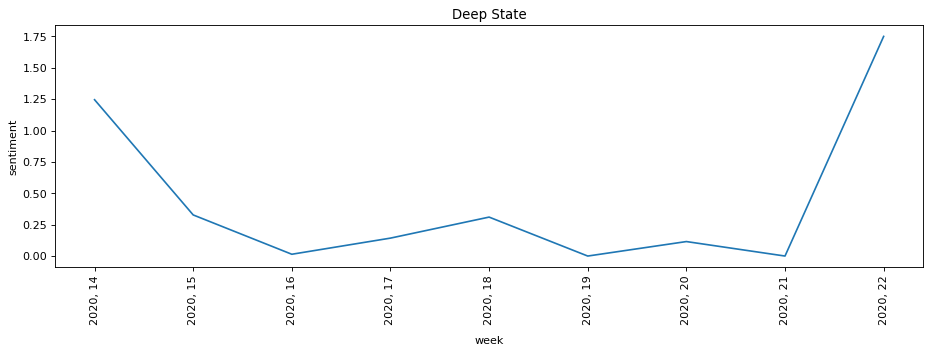

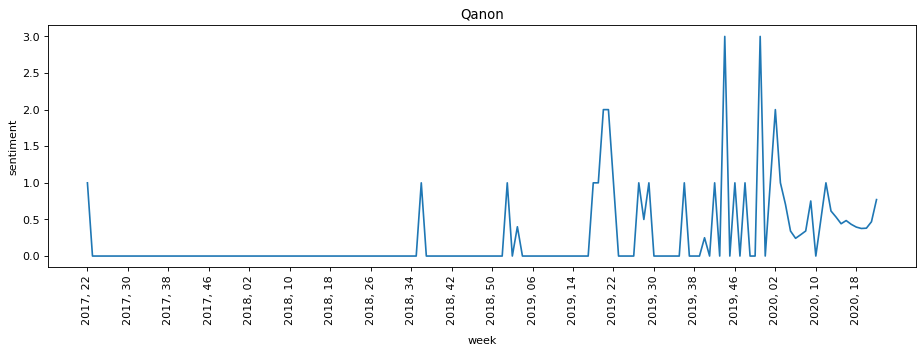

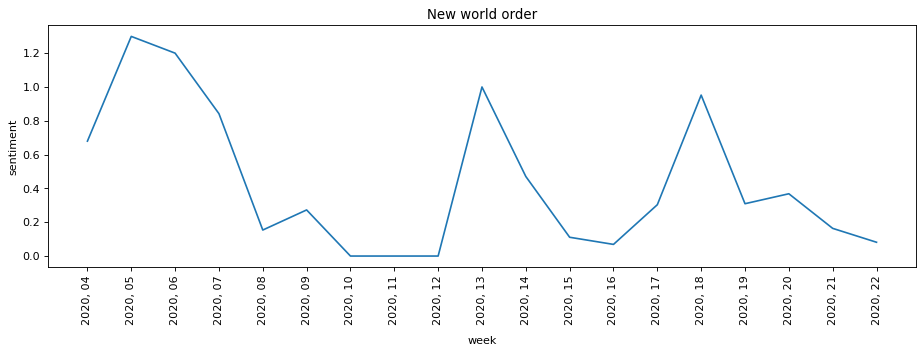

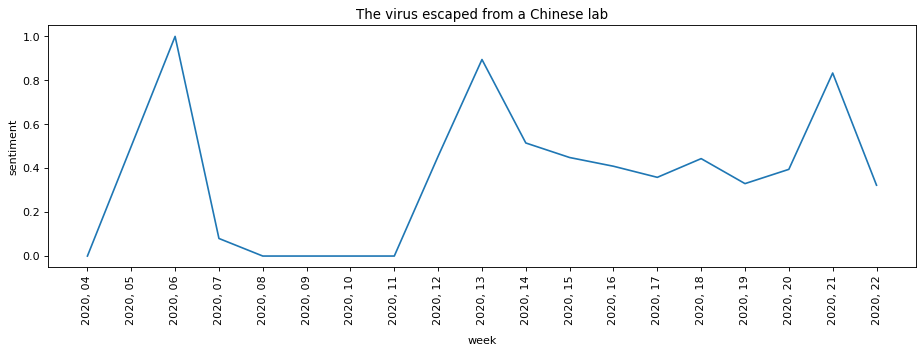

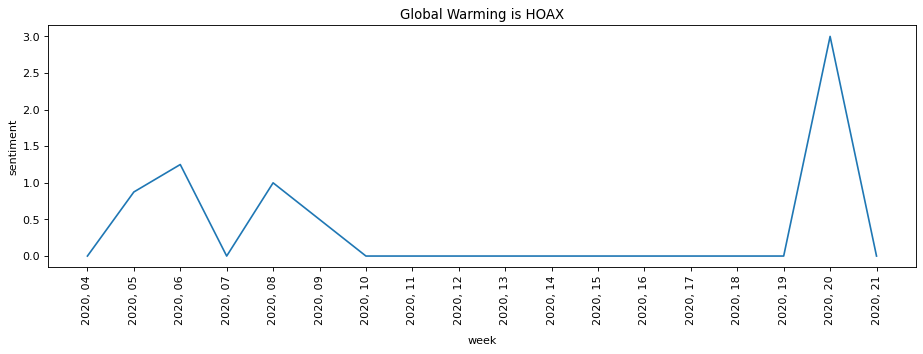

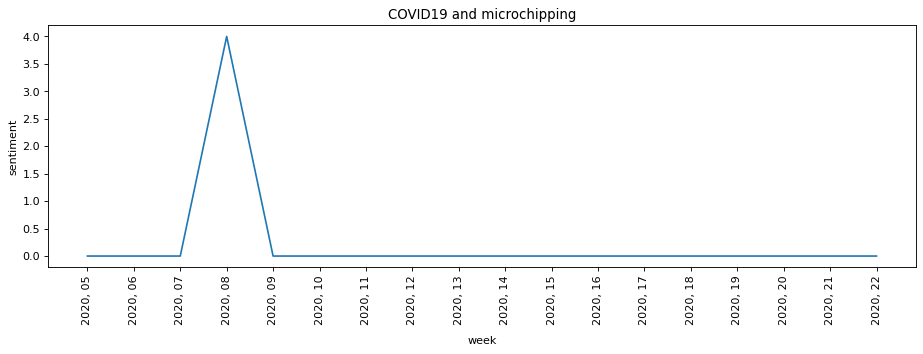

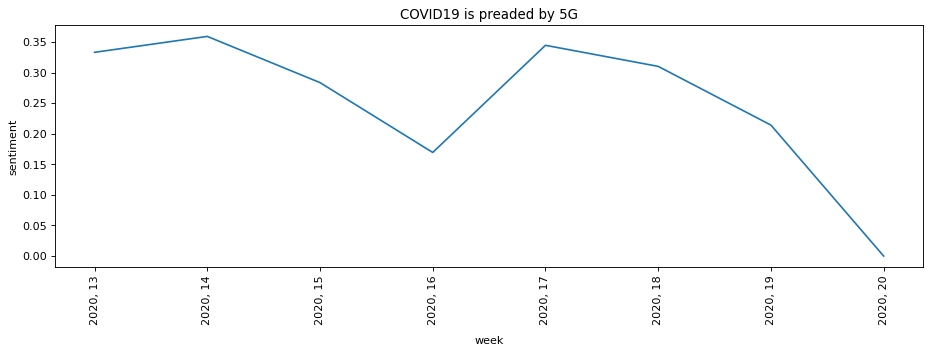

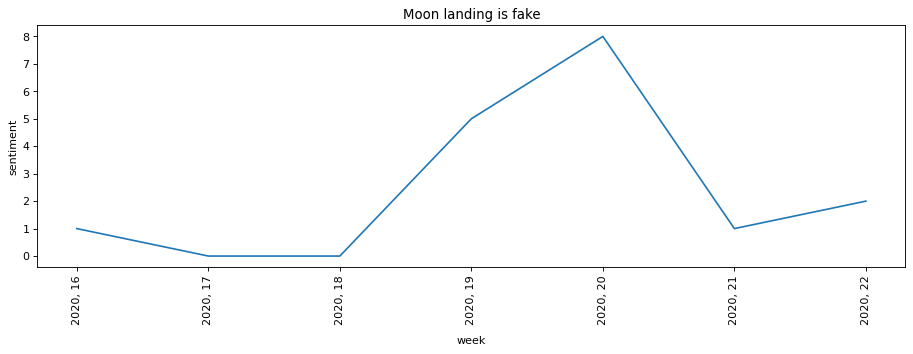

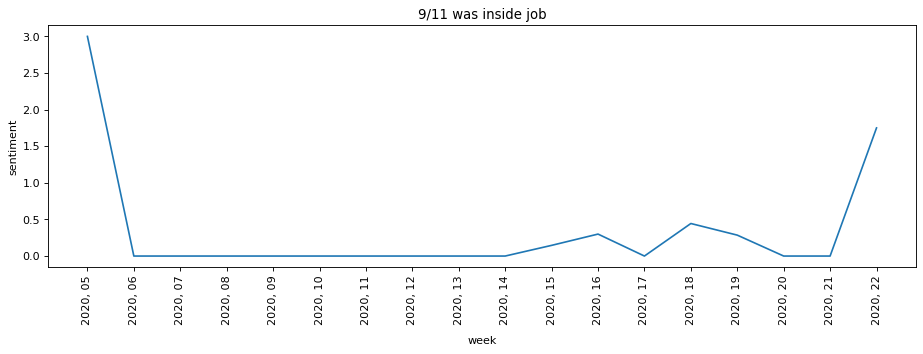

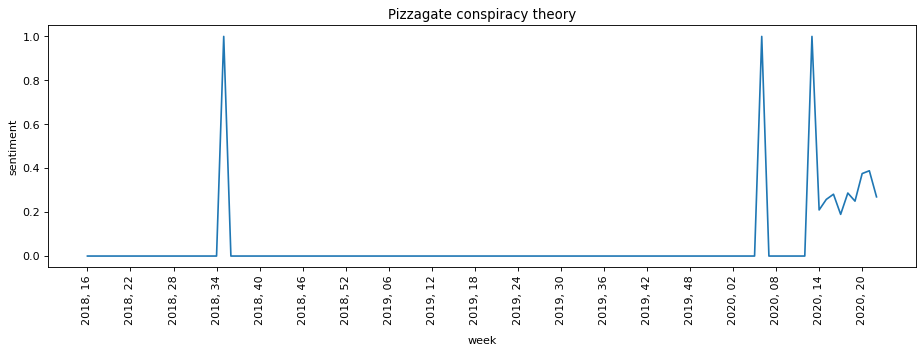

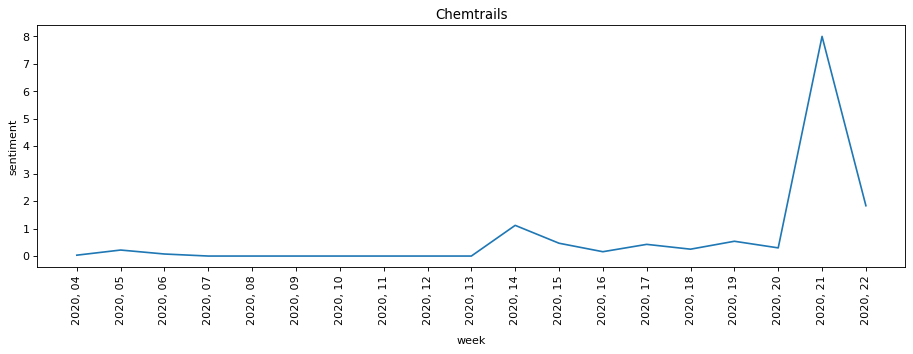

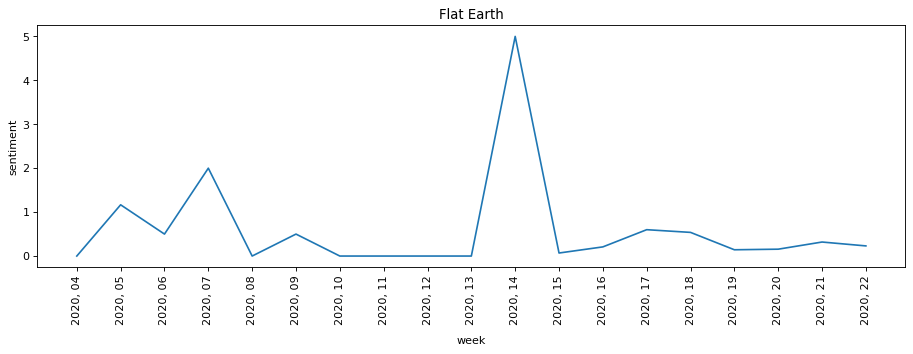

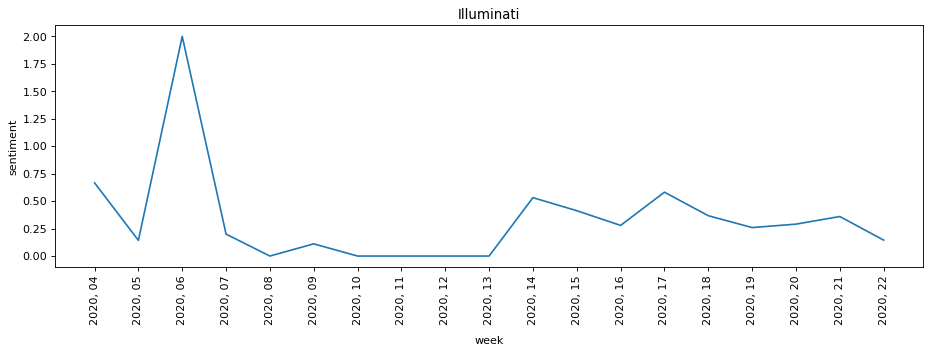

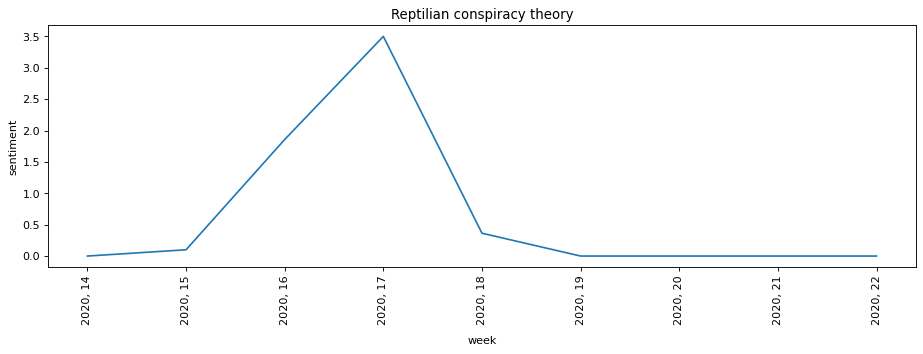

In [31]:
import matplotlib.pyplot as plt

# For some conspiracies we have too many weeks of sentiment data.
# For displaying the labels of x-axis properly we need to reduce
# the amount of displayed xticks manually by using this function
def reduce_xticks(xticks, xtick_names, limit):
    if len(xticks)<=limit:
        return xticks, xtick_names
    reduced_xticks = []
    reduced_xtick_names = []
    count=len(xticks)
    for i in range(0,count,round(count/limit)):
        reduced_xticks.append(xticks[i])
        reduced_xtick_names.append(xtick_names[i])
    
    return reduced_xticks, reduced_xtick_names
        
# Loop through all the conspiracies
for c in range(len(conspiracies)):
    # Increase figure sizes
    plt.figure(figsize=(14, 4), dpi=80)
    
    # Generate and reduce xticks, xtick names
    xticks=range(len(charts_weeks[c]))
    xtick_names=tuple('  '+str(e[0])+', '+str(e[1]).zfill(2) for e in charts_weeks[c])
    reduced_xticks, reduced_xtick_names = reduce_xticks(xticks, xtick_names, 20)
    
    # Plot all xticks, label reduced xticks
    plt.plot(xticks,charts_sentiments[c])
    plt.xticks(reduced_xticks,reduced_xtick_names,rotation='vertical')
    
    # Set chart title & axis labels
    plt.title(conspiracies[c])
    plt.xlabel('week')
    plt.ylabel('sentiment')
    
    # Render the chart
    plt.show()

## Task 5 - Find Top 10 most active accounts in all extreme sentiment conspiracy theories

## Task 6 - Find Top 10 most used hashtags for each exteme sentiment conspiracy theories 